## KAIM 2019

##  Understanding Deep Neural Networks Through Compositional Pattern-Producing Networks (CPPN)
### -Anand Krish

In [457]:
import torch
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
from PIL import Image
import numpy as np

In [432]:
class CPPN(nn.Module):
    def __init__(self, batch_size, net_size, h_size, x_res, y_res, scaling, RGB):
        
        super(CPPN, self).__init__()
        self.batch_size = batch_size
        self.net_size = net_size
        self.x_res = x_res
        self.y_res = y_res
        self.h_size = h_size
        self.scaling = scaling
        
        # Set Number of Channels
        if RGB:
            self.c_dim = 3
        else:
            self.c_dim = 1
        
        self.num_pts = self.x_res * self.y_res
        
        self.hid_vec = 2*torch.rand(self.batch_size, self.h_size) -1       
        self.hid_vec = self.hid_vec.unsqueeze(1)*torch.ones(self.num_pts,1)*self.scaling
        self.hid_vec = self.hid_vec.view(self.batch_size*self.num_pts, self.h_size)
               
        self.x,self.y,self.r = self.create_grid()
        self.build_network()
    
    def create_grid(self):
        x_range = torch.linspace(-1*self.scaling, self.scaling, self.x_res)
        y_range = torch.linspace(-1*self.scaling, self.scaling, self.y_res)

        xx,yy = torch.meshgrid(x_range, y_range)
        r = torch.sqrt((xx*xx).t() + (yy*yy).t())
        
        xx = xx.t().flatten().repeat(1,self.batch_size).view(-1,1)
        yy = yy.t().flatten().repeat(1,self.batch_size).view(-1,1)
        r = r.flatten().repeat(1,self.batch_size).view(-1,1)
        
        self.insize = xx.size(1)
        return xx,yy,r
    
    def build_network(self):        
        
        self.fc1 = nn.Linear(self.hid_vec.size(1), self.net_size, bias = True)
        self.fc2 = nn.Linear(self.insize, self.net_size, bias = False) 
        self.fc3 = nn.Linear(self.insize, self.net_size, bias = False) 
        self.fc4 = nn.Linear(self.insize, self.net_size, bias = False)
        
        
        self.model1 = nn.Sequential(
                       nn.Linear(self.net_size, self.net_size),
                       nn.Tanh(),
                       nn.Linear(self.net_size, self.net_size),
                       nn.Tanh(),
                       nn.Linear(self.net_size, self.net_size),
                       nn.Tanh(),
                       nn.Linear(self.net_size, self.c_dim),
                       nn.Sigmoid())
        
        
        self.model2 = nn.Sequential(
                        nn.Linear(self.net_size, self.net_size),
                        nn.Tanh(),
                        nn.Linear(self.net_size, self.net_size),
                        nn.Softplus(),
                        nn.Linear(self.net_size, self.net_size),
                        nn.Tanh(),
                        nn.Linear(self.net_size, self.c_dim),
                        nn.Softplus(),
                        )
    def forward(self):
        h =  self.fc1(self.hid_vec.squeeze()) + self.fc2(self.x) + self.fc3(self.y) + self.fc4(self.r)
        h = torch.tanh(h)
        h = self.model1(h)
        #h = self.model2(h)
        return h

In [476]:
#The weights of the network must be normally distributed for it to work
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight.data)

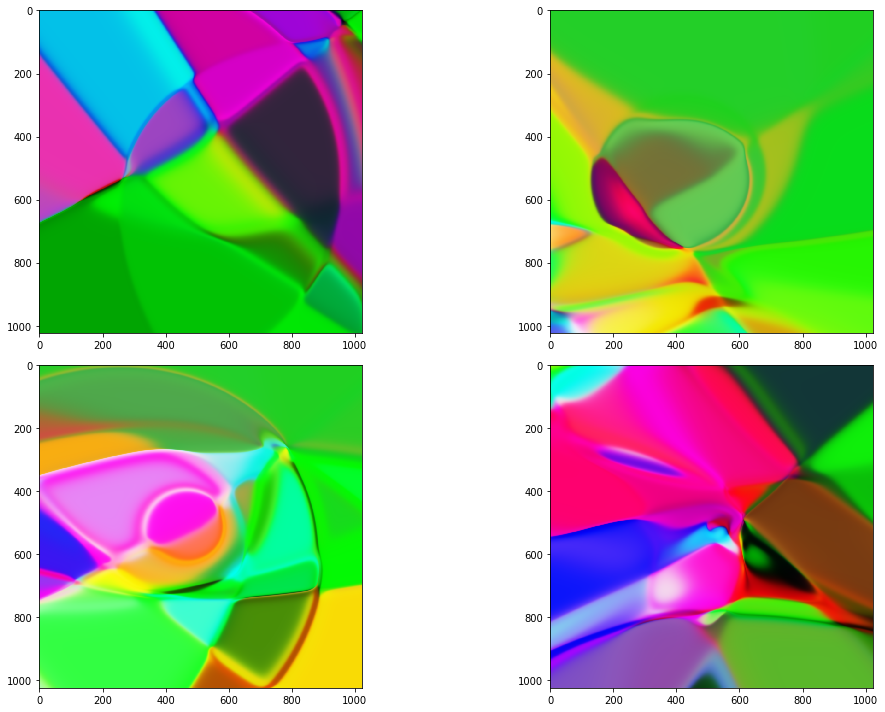

In [477]:
D = 1024
RGB = True
batch_size = 4
net_size = 16 
h_size = 8 
x_res = D
y_res = D
scaling =10

m = CPPN(batch_size, net_size, h_size, x_res, y_res, scaling, RGB)
m.apply(weights_init)
with torch.no_grad():
 h = m()

h = h.view(batch_size, D*D, -1)
plt.figure(figsize=(16, 10))
for i in range(batch_size):
    plt.subplot(2,batch_size/2,i+1)
    if RGB:
        plt.imshow(h[i].view(D, D, -1).numpy(), interpolation='nearest')
    else:
        plt.imshow(h[i].view(D, D).numpy(), cmap='bone',interpolation='nearest')
plt.tight_layout()

In [401]:
# a = np.random.randn(4,1,5)
# b = np.ones((6,1))
# a*b